From their website: "Stan is a state-of-the-art platform for statistical modeling and high-performance statistical computation. Thousands of users rely on Stan for statistical modeling, data analysis, and prediction in the social, biological, and physical sciences, engineering, and business."

Stan is written in c++ but has its own syntax --- it's a programming language in its own right! You can do three things with Stan:
- MCMC sampling with a default Hamiltonian Monte Carlo 'No-U-Turn Sampler' (NUTS) engine
- Variational inference
- Optimization
We will be learning how to sample model posteriors with the NUTS engine. 

Stan itself can be used through various interfaces, of which we will be using PyStan. PyStan can be installed with pip and conda.  You want to install a copy of the python environment I am using, run the following command in your terminal:
> conda env create -f environment.yml

If you install from the provided env yaml file, please make sure you run the above command in the correct directory. 
Otherwise, follow instructions for installing __[PyStan](https://pystan.readthedocs.io/en/latest/index.html)__ in the environment of your choosing.  Make sure to install PyStan version 3.5!

Stan has a __[reference manual](https://mc-stan.org/docs/reference-manual/index.html)__ and a __[user's guide](https://mc-stan.org/docs/stan-users-guide/index.html)__. Use the reference manual to answer syntax and library questions and check out the user's guide for various model implementation walkthroughs and coding advice.

On to using Stan...

In [1]:
# Importing PyStan is easy:
import stan

Let's familiarize ourselves with the basis structures of a Stan program before we dive into using PyStan.  Go ahead and open the file 'lin_regress.stan'.  You'll see the three blocks `data`, `parameters`, and `model` with their code contained within curly brackets.  Stan's c++ lineage is readily apparent: variables are declared with explicit typing, curly brackets determine scope, and semicolons denote end-of-line. Some data types are specific to Stan, such as `unit_vector` and `cov_matrix`. Also, floats and integers are accessible only as `real` and `int` types. 

Variables can have bounds unless they are instantiated in the 'model' block.  For examples, a Gaussian scale parameter $\sigma$ can (and should) be bound to be positive (see 'lin_regress.stan' example).

Within each code block, all global variables _must_ be declared before any other logic. Local variables can be defined within loops, but otherwise a variable defined at the beginning of most code blocks are global (this is not true for the model code block --- those variables are always local, but you still need to define any variable throughout the model block scope before any logic!)

Finally, the '~' operator in Stan is an operator (called somewhat erroneously the 'sampling statement').  This operator appends the target log probability and is used when specifying your likelihood or any priors in your model. 

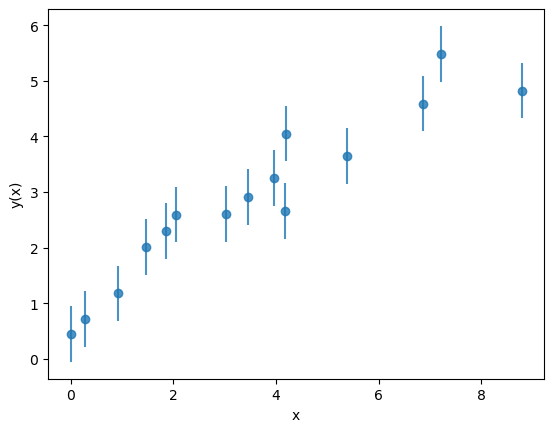

In [78]:
# Let's generate some data for our regression model:
from scipy.stats import uniform, norm
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(seed=1)

n = 15 # number of samples
m = 0.5 # slope
b = 1. # intercept
# x = uniform(loc=-5., scale=10.).rvs(size=n) # random predictor variable sample of length n
x = uniform(loc=0., scale=10.).rvs(size=n) # random predictor variable sample of length n


sigma = 0.5 # noise term:
err_dist = norm(loc=0., scale=sigma) # Error distribution(?)

y = m * x + b + err_dist.rvs(size=n) # dependent, or outcome variable sample

# plot our data:
plt.errorbar(
    x, y, yerr=sigma, ls='', marker='o', alpha=0.8
)
plt.xlabel('x')
plt.ylabel('y(x)')

plt.show()

How we generated this data is consistent with how we are trying to regress it using Stan. That said, Stan's framework is fundamentally Bayesian, so our maximized/sampled posterior requires priors on model parameters (in the case, $m$, $b$, and $\sigma$). If no prior is provided explicitly (as is the case for $m$ and $b$), then an implicit uniform prior along the bounds of that parameter is used. 

Placing priors on Stan is straightforward and is done in the model code block.  For example, say we want to place 'soft' bounds on our linear model parameters to keep these variables of order $\pm1$.  Placing normal priors on centered at zero with standard deviations of five would do the trick:
```stan
m ~ normal(0, 5);
b ~ normal(0, 5);
```
Feel free to add these priors to your 'lin_regression.stan' code.  Note that you can add them before or after the likelihood sampling statement.  Order does not matter in this case!



In [88]:
# Needed to run PyStan in Jupyter:
import nest_asyncio
nest_asyncio.apply()

# Input for Stan is a dictionary:
data = {
    'N_data': n,
    'x': x,
    'y': y
}

# you can either provide your code as a string, or just import it:
with open('lin_regress.stan', 'r') as f:
    stan_script = f.read()

# We first build a Stan program using our script and data:
model = stan.build(stan_script, data=data)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


We are going to sample our posterior using Stan's build-in NUTS compiler.  That means we need to provide an iteration count and the number of chains that'll be exploring our posterior.  

We also can provide initial conditions for each chain if one desires.  This is particularly useful for higher-dimensional problems, since it places the samplers on your posterior (hopefully) near your model's mode!  Initial conditions are provided per-chain as a list of dictionaries.  For more complex models it is recommended that you provide some noise to each chain's initial conditions so that you do not get stuck in a local maximum!

In [89]:
# Let's specify inputs for our sampling:
n_chains = 4
n_iterations = 2000
init_list = [{'m': 0.5, 'b': 1., 'sigma': 0.5}] * n_chains

# fitting is easy!:
fit = model.sample(num_chains=n_chains, num_samples=n_iterations, init=init_list)

Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 0.000287 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.87 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.002117 seconds
  1000 transitions using 10 leapfrog steps per transition would take 21.17 seconds.
  Adjust your expectations accordingly!


m true, mean fit: 0.5 0.532
b true, mean fit: 1.0 0.982
sigma true, mean fit: 0.5 0.55


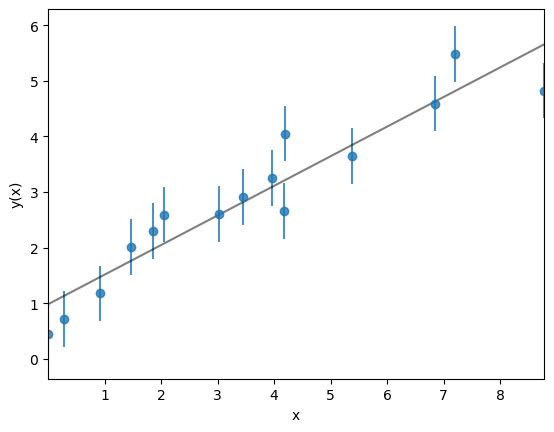

In [90]:
# from scipy import 
# you can extract parameter results directly from the 'fit' object:
m_mean = np.mean(fit['m'])
b_mean = np.mean(fit['b'])
sigma_mean = np.mean(fit['sigma'])
print('m true, mean fit:', m, round(m_mean, 3))
print('b true, mean fit:', b, round(b_mean, 3))
print('sigma true, mean fit:', sigma, round(sigma_mean, 3))

# Let's check out our results!
x_plot = np.linspace(np.min(x), np.max(x), 100)



plt.errorbar(
    x, y, yerr=sigma, ls='', marker='o', alpha=0.8
)
plt.plot(x_plot, m_mean * x_plot + b_mean, alpha=0.5, color='black')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.xlim([x_plot[0], x_plot[-1]])
plt.show()

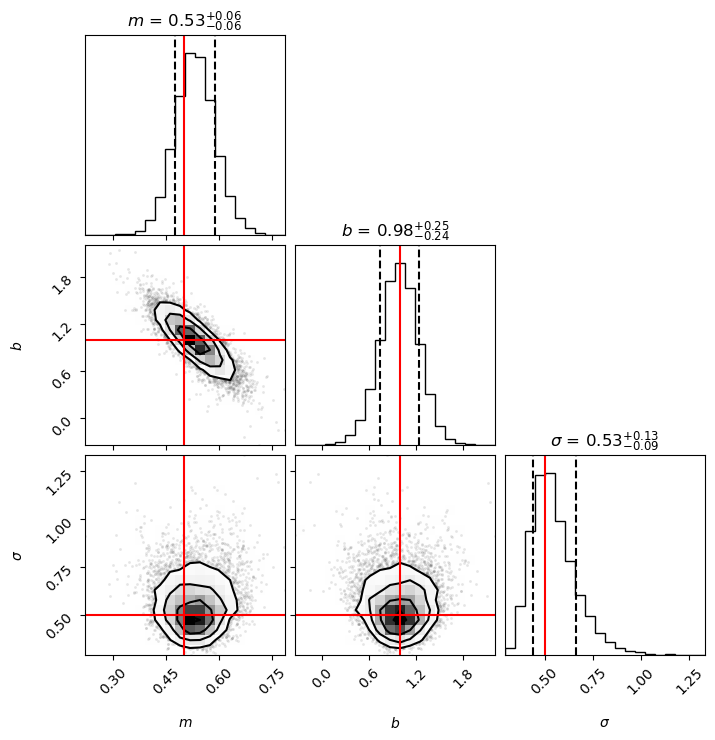

In [91]:
# Corner plot time
import corner
corner_sample = np.vstack((fit['m'], fit['b'], fit['sigma']))

figure = corner.corner(
    corner_sample.T,
    labels=[
        r'$m$',
        r'$b$',
        r'$\sigma$'
    ],
    quantiles=[0.16, 0.84],
    show_titles=True,
    title_kwargs={'fontsize': 12},
)

# Add our true values as red lines:
figure.axes[0].axvline(m, color='red')
figure.axes[3].axvline(m, color='red')
figure.axes[3].axhline(b, color='red')
figure.axes[6].axvline(m, color='red')
figure.axes[6].axhline(sigma, color='red')
figure.axes[4].axvline(b, color='red')
figure.axes[7].axvline(b, color='red')
figure.axes[7].axhline(sigma, color='red')
figure.axes[8].axvline(sigma, color='red')
plt.show()

Linear regression can benefit from centering our data before regressing.  Instead of doing this with python before feeding centered data into Stan, we can use the 'transformed data' and 'generated quantities' code blocks.  

Open up the script 'lin_regress_centered.stan' for to see what changed!

In [92]:
# compile and generate centered regression stan model:
with open('lin_regress_centered.stan', 'r') as f:
    stan_centered_script = f.read()

centered_model = stan.build(stan_centered_script, data=data)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/1v/2wqw3rzx3qg41mbj638bc10c0000gn/T/httpstan_afw5qzaa/model_roemhyzt.stan', line 49, column 4: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [93]:
# fit centered model
n_chains = 4
n_iterations = 2000
init_list = [{'m': 0.5, 'b': 1., 'sigma': 0.5}] * n_chains

fit_centered = centered_model.sample(num_chains=n_chains, num_samples=n_iterations, init=init_list)

Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 0.001242 seconds
  1000 transitions using 10 leapfrog steps per transition would take 12.42 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/var/folders/1v/2wqw3rzx3qg41mbj638bc10c0000gn/T/httpstan_y__puj3t/model_roemhyzt.stan', line 40, column 4 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 0.001254 seconds
  1000 transitions using 10 

m true, fit, m_cent fit: 0.5 0.532 0.945
b true, fit, b_cent fit: 1.0 0.985 0.001
sigma true, fit, sigma_cent fit: 0.5 0.558 0.378


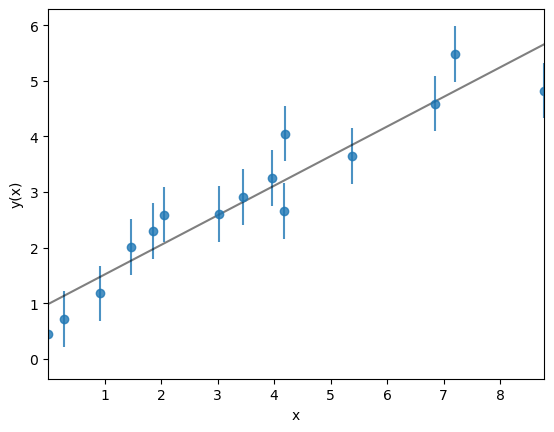

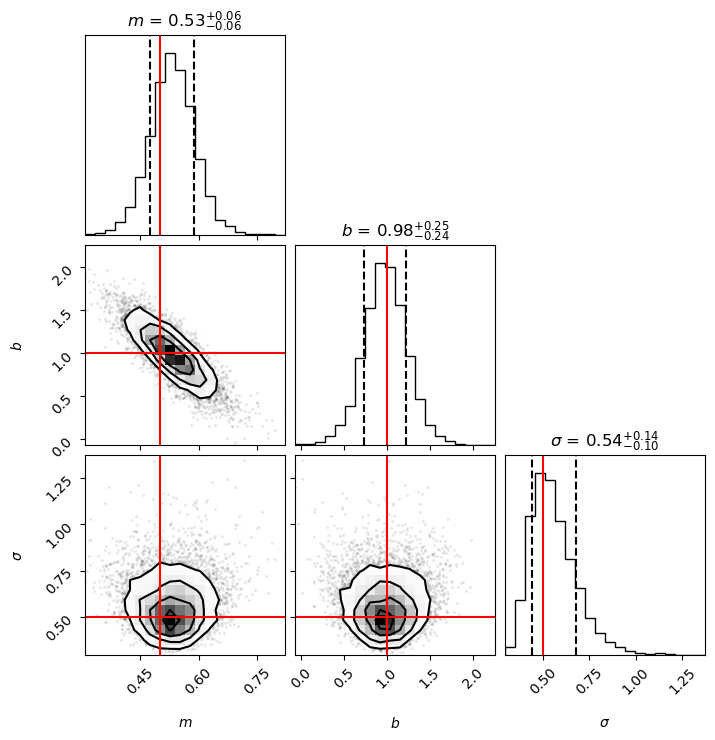

In [94]:
m_mean = np.mean(fit_centered['m'])
b_mean = np.mean(fit_centered['b'])
sigma_mean = np.mean(fit_centered['sigma'])
print('m true, fit, m_cent fit:', m, round(m_mean, 3), round(np.mean(fit_centered['m_cent']), 3))
print('b true, fit, b_cent fit:', b, round(b_mean, 3), round(np.mean(fit_centered['b_cent']), 3))
print('sigma true, fit, sigma_cent fit:', sigma, round(sigma_mean, 3), round(np.mean(fit_centered['sigma_cent']), 3))

# Let's check out our results!
x_plot = np.linspace(np.min(x), np.max(x), 100)

plt.errorbar(
    x, y, yerr=sigma, ls='', marker='o', alpha=0.8
)
plt.plot(x_plot, m_mean * x_plot + b_mean, alpha=0.5, color='black')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.xlim([x_plot[0], x_plot[-1]])
plt.show()

corner_sample = np.vstack((fit_centered['m'], fit_centered['b'], fit_centered['sigma']))

figure = corner.corner(
    corner_sample.T,
    labels=[
        r'$m$',
        r'$b$',
        r'$\sigma$'
    ],
    quantiles=[0.16, 0.84],
    show_titles=True,
    title_kwargs={'fontsize': 12},
)

# Add our true values as red lines:
figure.axes[0].axvline(m, color='red')
figure.axes[3].axvline(m, color='red')
figure.axes[3].axhline(b, color='red')
figure.axes[6].axvline(m, color='red')
figure.axes[6].axhline(sigma, color='red')
figure.axes[4].axvline(b, color='red')
figure.axes[7].axvline(b, color='red')
figure.axes[7].axhline(sigma, color='red')
figure.axes[8].axvline(sigma, color='red')
plt.show()